In [1]:
# Imports
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm
from data import load_h5py_file
from scipy.ndimage import gaussian_filter1d

from config import Configurator

Config = Configurator(phoneme=False)
device = Config.DEVICE

In [2]:
path = Configurator.DATA_PATH
folders = os.listdir(path)
test_files = []
for i, files in enumerate(folders):
    if files.startswith("."):
        continue
    files = os.listdir(os.path.join(path, files))
    for file in files:
        if file.endswith("test.hdf5"):
            test_files.append(os.path.join(path, folders[i], file))

test_df = pd.DataFrame()
for file in tqdm(test_files, desc="Loading Test files"):
    data = load_h5py_file(file)
    temp_df = pd.DataFrame(data)
    test_df = pd.concat([test_df, temp_df], ignore_index=True)

Loading Test files:   0%|          | 0/41 [00:00<?, ?it/s]

In [3]:
class TestDataset(Dataset):
    """
    Expects a DataFrame with columns:
      - 'neural_features': np.ndarray shape (T, 512)  (dtype float or similar)
    """

    def __init__(self, df: pd.DataFrame, blank_id: int = 128, smoothing=False):
        # sort the dataframe by session
        self.df = df.sort_values(by=['session']).reset_index(drop=True)
        self.blank_id = blank_id

        self.smoothing = smoothing

        # Apply smoothing preemptively if needed
        if self.smoothing:
            for i in range(len(self.df)):
                self.df.at[i, 'neural_features'] = gaussian_filter1d(self.df.at[i, 'neural_features'], sigma=2, axis=0)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        x_arr = self.df.iloc[idx]['neural_features']  # (T, 512)
        x = torch.tensor(x_arr, dtype=torch.float32)  # (T, 512)
        session = self.df.iloc[idx]['session']

        return x, session

def collate_fn(batch, batch_first: bool = True):
    """
    batch: list of tuples (x, session)
      - x: (T, 512) tensor
      - session: str
    Returns:
      - x_pad: (B, T_max, 512) tensor
      - x_len: (B,) tensor
      - sessions: list of str
    """
    xs, sessions = zip(*batch)
    x_lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)  # (B,)
    # Pad inputs
    xs_padded = pad_sequence(xs, batch_first=batch_first)  # (B, T_max, 512) or (T_max, B, 512)
    return xs_padded, x_lengths, sessions

test_dataset = TestDataset(test_df, smoothing=True)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, batch_first=Config.BATCH_FIRST),
)

In [4]:
from models import ConformerCTC

In [5]:
model = ConformerCTC(
    input_dim=Config.FEATURE_LEN,
    vocab_size=Config.VOCAB_SIZE,
    model_dim=256,
    num_layers=8,
    num_heads=4,
    ff_dim=512,
    dropout=0.2,
    max_seq_len=3000,
    batch_first=Config.BATCH_FIRST,
).to(device)

In [6]:
from losses import CTCLoss, FocalCTCLoss

In [7]:
loss = CTCLoss(blank_id=Config.BLANK_ID, reduction="mean")
# loss = FocalCTCLoss(blank_id=Config.BLANK_ID, alpha=0.5, gamma=2.0, reduction='mean')

# model_checkpoint_path = f"{Config.MODEL_PATH}{model}_{loss}_{Config.MODEL_STR}"
model_checkpoint_path = f"/Users/valentinlhermitte/Developer/PycharmProjects/BrainToText2025/models/text_models/conformer_ctc_8_layers_CTCLoss__best_model.pt"

checkpoint = torch.load(model_checkpoint_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)

# number of model parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params:,} total parameters.")
print(f"Model has {num_trainable_params:,} trainable parameters.")
print(model.describe())

Model has 8,146,561 total parameters.
Model has 8,146,561 trainable parameters.
Conformer CTC Model:
  Input Dim: 512
  Conformer Layers: 8
  Output Vocab Size: 129



In [8]:
from evaluation import greedy_decode, beam_search_decode
from pyctcdecode import build_ctcdecoder
from llm_utils import LocalLLMCorrector

In [9]:
# Inference loop
model.eval()
cer_total, wer_total = 0.0, 0.0
results = {
        "sessions": [],
        "llm_corrected": []  # Add this to track changes
    }

# 1. Initialize Decoder (Standard KenLM)
labels = [chr(i) for i in range(128)] + ['']  # ASCII + blank
decoder = build_ctcdecoder(
    labels=labels,  # ASCII + blank
    kenlm_model_path="../corpuses/wikipedia/en.arpa.bin",
    alpha=0.5,  # Weights for LM
    beta=1.0,  # Bonus for word length (can help prevent very short outputs)
)

# 2. Initialize LLM (New)
llm_corrector = None
if Configurator.USE_LLM_CORRECTION:
    try:
        # llm_corrector = LocalLLMCorrector(Configurator.LLM_MODEL_PATH)
        llm_corrector = None
    except Exception as e:
        print(f"Skipping LLM: {e}")

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Inference on test set"):
        x, x_len, sessions = batch
        x = x.to(device)  # (B, T, 512)
        x_len = x_len.to(device)  # (B,)
        logits, _ = model(x, x_len)

        # decode IDs (already CTC-decoded: blanks removed in greedy_decode)
        if Configurator.USE_BEAM_SEARCH_DECODING:
            pred_ids_batch = beam_search_decode(decoder, logits, batch_first=Configurator.BATCH_FIRST, is_log_probs=False)
        else:
            pred_ids_batch = greedy_decode(logits, blank_id=blank_id)

        # build reference & hypothesis text sequences
        for i in range(len(x_len)):
            session = sessions[i]

            if Config.USE_BEAM_SEARCH_DECODING:
                hyp_text = pred_ids_batch[i][0]  # Best beam
            else:
                hyp_ids = pred_ids_batch[i]
                hyp_text = "".join([chr(id_) for id_ in hyp_ids])

            # Apply LLM correction if enabled
            final_text = hyp_text
            if llm_corrector:
                # Only correct if the sentence is somewhat long to avoid noise
                if len(hyp_text) > 3:
                    corrected = llm_corrector.correct_text(hyp_text)
                    # Fallback: if LLM returns empty or hallucinated short text, keep original
                    if len(corrected) > 0:
                        final_text = corrected
            results["sessions"].append(session)
            results["llm_corrected"].append(final_text)  # Corrected
            print(f"Session: {session} | Hyp: {hyp_text} | Final: {final_text}")

Unigrams not provided and cannot be automatically determined from LM file (only arpa format). Decoding accuracy might be reduced.
No known unigrams provided, decoding results might be a lot worse.


Inference on test set:   0%|          | 0/91 [00:00<?, ?it/s]

Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:   | Final:  
Session: t15.2023.08.13 | Hyp:  

In [10]:
df = pd.DataFrame(results)

# Sort by session to ensure correct order
df = df.sort_values(by=['sessions']).reset_index(drop=True)
df = df.rename(columns={"llm_corrected": "text"})
# Add column id (each id corresponds to the session order)
df.insert(0, 'id', range(len(df)))
# Drop session column
df = df.drop(columns=['sessions'])

df.to_csv(f"../submissions/submission_{model}.csv", index=False)

In [11]:
import matplotlib.pyplot as plt

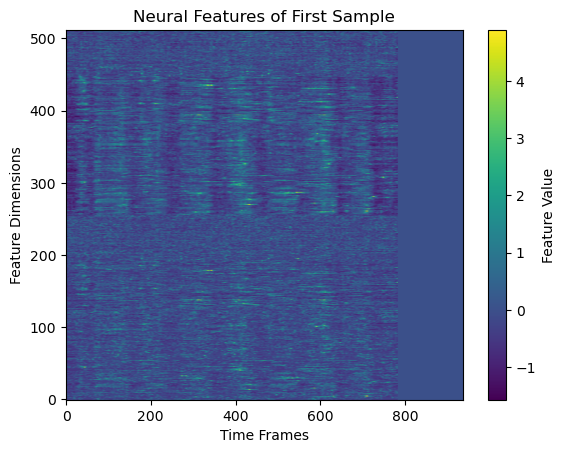

In [12]:
sample = next(iter(test_dataloader))
inputs, input_lengths, sessions = sample

first_sample_features = inputs[1].cpu().numpy()
plt.imshow(first_sample_features.T, aspect='auto', origin='lower')
plt.title("Neural Features of First Sample")
plt.xlabel("Time Frames")
plt.ylabel("Feature Dimensions")
plt.colorbar(label="Feature Value")
plt.show()